In [0]:
import os
import sys
import pandas
import numpy as np
from google.colab import drive
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import  Sequential, Model
from keras.layers import  Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

In [55]:
drive.mount('/content/gdrive/')

root_path = '/content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits'
sys.path.append(root_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
raw = pandas.read_csv(os.path.join(root_path, 'train.csv')).values
x_validation = pandas.read_csv(os.path.join(root_path, 'test.csv')).values

In [0]:
x_raw = raw[:, 1:]
y_raw = raw[:, 0]

x_raw = x_raw / 255
x_validation = x_validation / 255

x_raw = np.reshape(x_raw, (x_raw.shape[0], 28, 28, 1))
x_validation = np.reshape(x_validation, (x_validation.shape[0], 28, 28, 1))

y_raw = np_utils.to_categorical(y_raw, 10)

x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size = .2)


# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [0]:
# hyper parameters
epochs = 20
batch_size = 32
learning_rate = 0.01
momentum = 0.5
decay = learning_rate / epochs

In [0]:
checkpoint_name = "weights.epoch-{epoch:02d}.hdf5"
best_name = "best.weights.hdf5"
filepath = os.path.join(root_path, "Model/")

# callbacks
best_callback = ModelCheckpoint(filepath + best_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint_callback = ModelCheckpoint(filepath + checkpoint_name, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
scheduler = LearningRateScheduler(
    lambda epoch: learning_rate * 1/(1 + decay * epoch)
)

# optimizer
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum)

# data augmentation
generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

generator.fit(x_train)

In [60]:
# make the model
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(.25))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(.25))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=['accuracy'],
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 32)          18464     
__________

In [61]:
default_model_history = model.fit(
    x_train, y_train,
    batch_size = batch_size, epochs = epochs,
    validation_data = (x_test, y_test),
    callbacks=[checkpoint_callback, best_callback]
)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 10s 301us/step - loss: 1.2087 - acc: 0.5895 - val_loss: 0.2354 - val_acc: 0.9305

Epoch 00001: val_acc improved from -inf to 0.93048, saving model to /content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits/Model/best.weights.hdf5
Epoch 2/20
33600/33600 [==============================] - 10s 291us/step - loss: 0.2985 - acc: 0.9108 - val_loss: 0.1334 - val_acc: 0.9586

Epoch 00002: val_acc improved from 0.93048 to 0.95857, saving model to /content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits/Model/best.weights.hdf5
Epoch 3/20
33600/33600 [==============================] - 10s 291us/step - loss: 0.2040 - acc: 0.9416 - val_loss: 0.1065 - val_acc: 0.9686

Epoch 00003: val_acc improved from 0.95857 to 0.96857, saving model to /content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits/Model/best.weights.hdf5
Epoch 4/20
33600/33600 [==============================] - 10s 292u

In [62]:
lr_scheduler_model_history = model.fit(
    x_train, y_train,
    batch_size = batch_size, epochs = epochs,
    validation_data = (x_test, y_test),
    callbacks=[checkpoint_callback, best_callback, scheduler]
)

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 10s 294us/step - loss: 0.0382 - acc: 0.9895 - val_loss: 0.0523 - val_acc: 0.9864

Epoch 00001: val_acc improved from 0.98631 to 0.98643, saving model to /content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits/Model/best.weights.hdf5
Epoch 2/20
33600/33600 [==============================] - 10s 300us/step - loss: 0.0354 - acc: 0.9900 - val_loss: 0.0592 - val_acc: 0.9860

Epoch 00002: val_acc did not improve from 0.98643
Epoch 3/20
33600/33600 [==============================] - 11s 330us/step - loss: 0.0332 - acc: 0.9899 - val_loss: 0.0672 - val_acc: 0.9843

Epoch 00003: val_acc did not improve from 0.98643
Epoch 4/20
33600/33600 [==============================] - 11s 324us/step - loss: 0.0326 - acc: 0.9906 - val_loss: 0.0500 - val_acc: 0.9869

Epoch 00004: val_acc improved from 0.98643 to 0.98690, saving model to /content/gdrive/My Drive/Colab Notebooks/nn-homework1/digits/Mod

In [63]:
data_generated_history = model.fit_generator(
    generator.flow(x_train, y_train, batch_size=batch_size),
    validation_data = (x_test, y_test),
    steps_per_epoch=len(x_train)/ batch_size,
    epochs=epochs
)

Epoch 1/20
1050/1050 [==============================] - 31s 30ms/step - loss: 0.6996 - acc: 0.8054 - val_loss: 0.2133 - val_acc: 0.9761
Epoch 2/20
1050/1050 [==============================] - 31s 29ms/step - loss: 0.3308 - acc: 0.9053 - val_loss: 0.1483 - val_acc: 0.9821
Epoch 3/20
1050/1050 [==============================] - 25s 24ms/step - loss: 0.2704 - acc: 0.9242 - val_loss: 0.1489 - val_acc: 0.9796
Epoch 4/20
1050/1050 [==============================] - 17s 16ms/step - loss: 0.2283 - acc: 0.9364 - val_loss: 0.1440 - val_acc: 0.9821
Epoch 5/20
1050/1050 [==============================] - 17s 16ms/step - loss: 0.2037 - acc: 0.9437 - val_loss: 0.1485 - val_acc: 0.9827
Epoch 6/20
1050/1050 [==============================] - 17s 16ms/step - loss: 0.1752 - acc: 0.9511 - val_loss: 0.1236 - val_acc: 0.9818
Epoch 7/20
1050/1050 [==============================] - 17s 16ms/step - loss: 0.1652 - acc: 0.9546 - val_loss: 0.1372 - val_acc: 0.9806
Epoch 8/20
1050/1050 [==========================

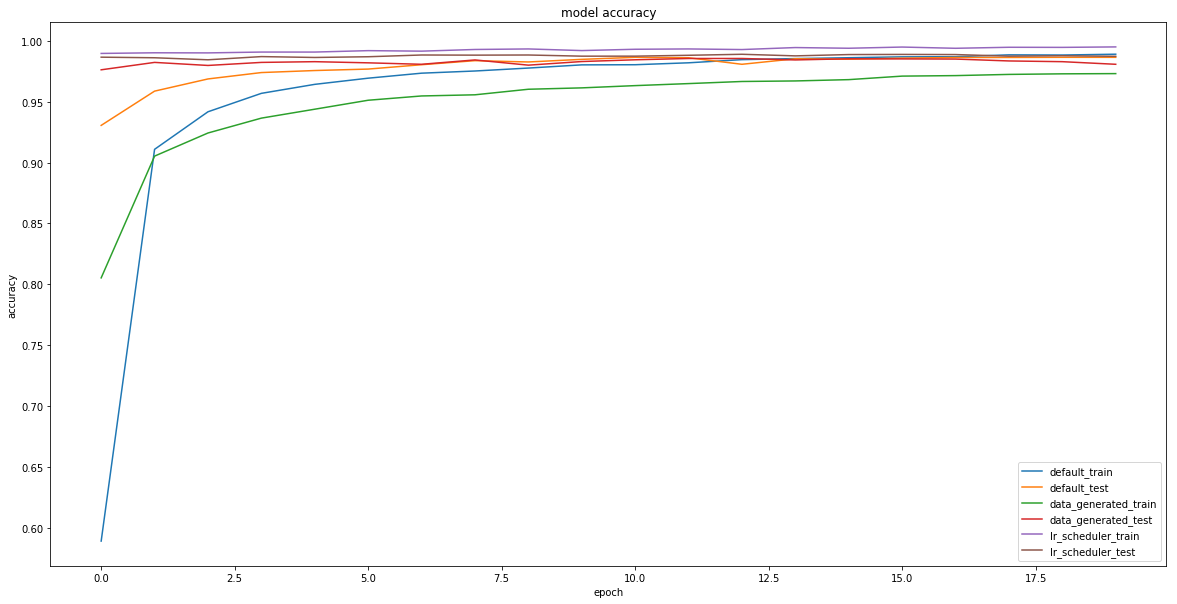

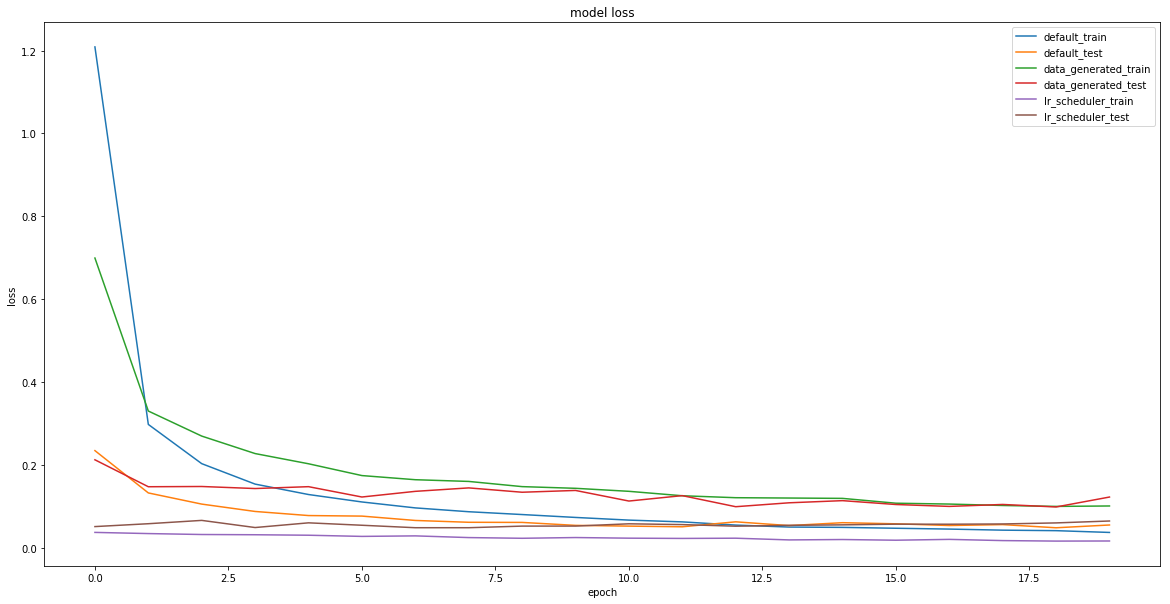

In [64]:
#  plot accuracy
plt.figure(figsize=(20, 10))
plt.plot(default_model_history.history['acc'])
plt.plot(default_model_history.history['val_acc'])

plt.plot(data_generated_history.history['acc'])
plt.plot(data_generated_history.history['val_acc'])

plt.plot(lr_scheduler_model_history.history['acc'])
plt.plot(lr_scheduler_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(
    [
        'default_train', 'default_test',
        'data_generated_train', 'data_generated_test',
        'lr_scheduler_train', 'lr_scheduler_test'
    ],
    loc='lower right')

plt.show()

#  plot loss
plt.figure(figsize=(20, 10))
plt.plot(default_model_history.history['loss'])
plt.plot(default_model_history.history['val_loss'])

plt.plot(data_generated_history.history['loss'])
plt.plot(data_generated_history.history['val_loss'])

plt.plot(lr_scheduler_model_history.history['loss'])
plt.plot(lr_scheduler_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(
    [
        'default_train', 'default_test',
        'data_generated_train', 'data_generated_test',
        'lr_scheduler_train', 'lr_scheduler_test',
    ],
    loc='upper right')

plt.show()

In [0]:
model.load_weights(filepath + "best.weights.hdf5")

In [66]:
layers = [layer.output for layer in model.layers]
temp_model = Model(inputs=model.input, output=layers)

sample_image = x_train[0]

output = temp_model.predict(sample_image.reshape(1, 28, 28, 1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  



 ______________________________________________________________________________________________________________________________________________________ 
 sample image:


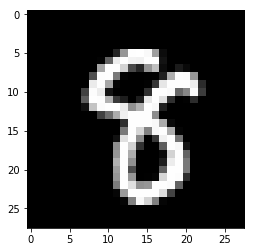


 ______________________________________________________________________________________________________________________________________________________ 
 conv2d_4/BiasAdd:0


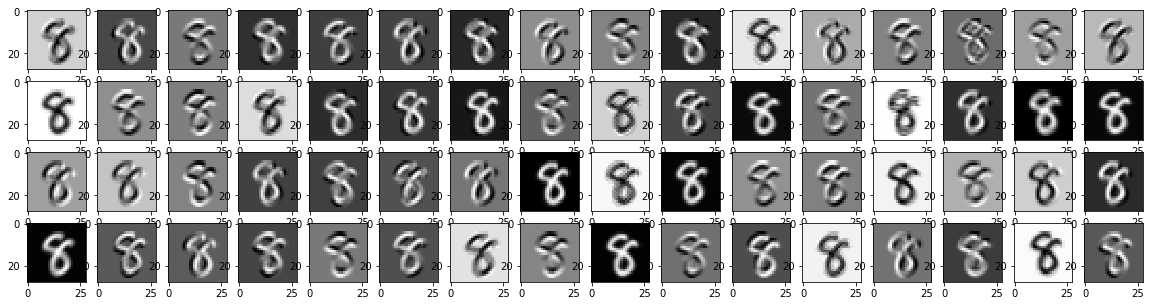


 ______________________________________________________________________________________________________________________________________________________ 
 activation_7/Relu:0


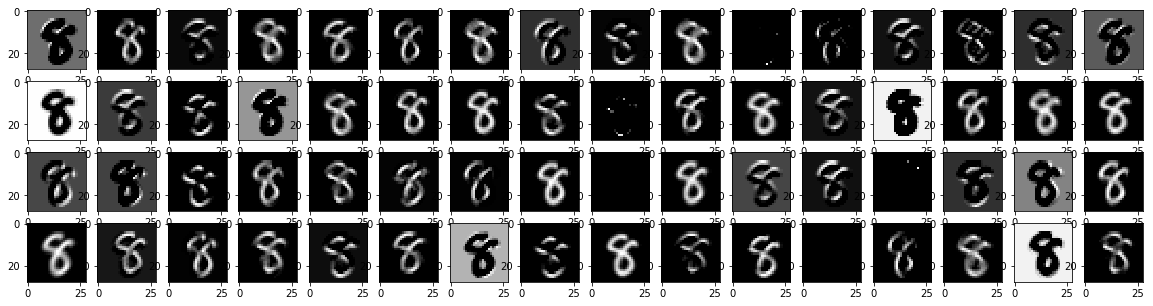


 ______________________________________________________________________________________________________________________________________________________ 
 max_pooling2d_4/MaxPool:0


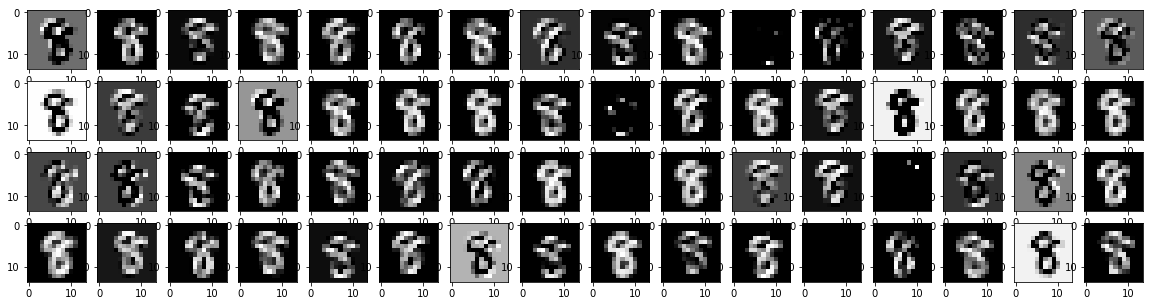


 ______________________________________________________________________________________________________________________________________________________ 
 conv2d_5/BiasAdd:0


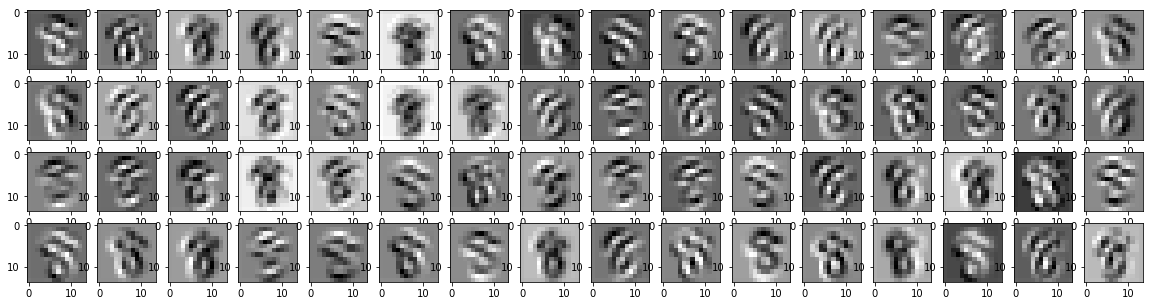


 ______________________________________________________________________________________________________________________________________________________ 
 activation_8/Relu:0


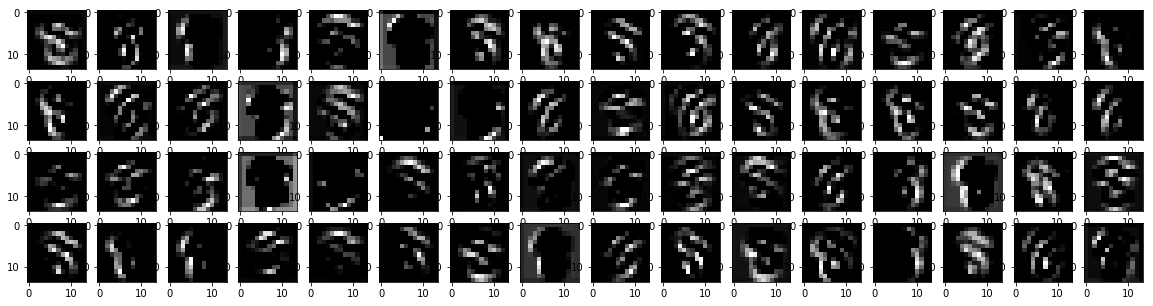


 ______________________________________________________________________________________________________________________________________________________ 
 max_pooling2d_5/MaxPool:0


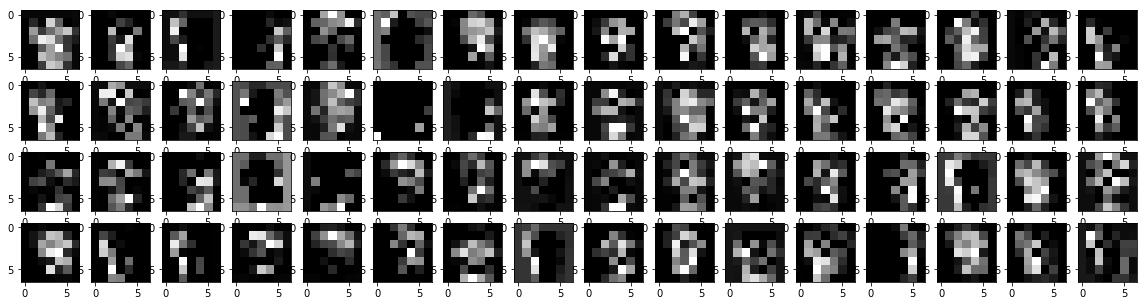


 ______________________________________________________________________________________________________________________________________________________ 
 conv2d_6/BiasAdd:0


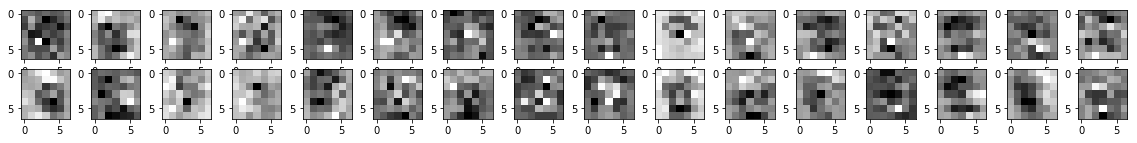


 ______________________________________________________________________________________________________________________________________________________ 
 activation_9/Relu:0


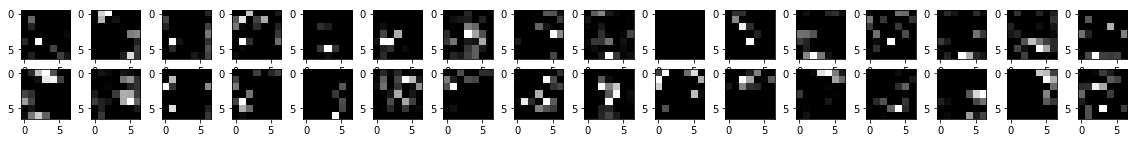


 ______________________________________________________________________________________________________________________________________________________ 
 max_pooling2d_6/MaxPool:0


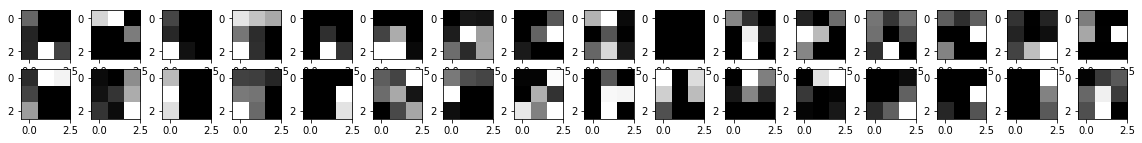


 ______________________________________________________________________________________________________________________________________________________ 
 flatten_2/Reshape:0


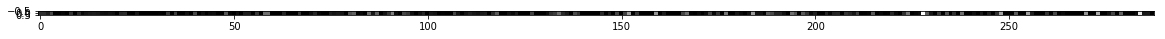


 ______________________________________________________________________________________________________________________________________________________ 
 dense_4/BiasAdd:0


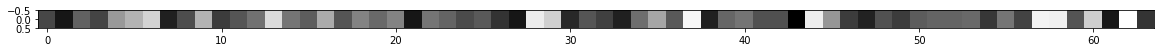


 ______________________________________________________________________________________________________________________________________________________ 
 activation_10/Relu:0


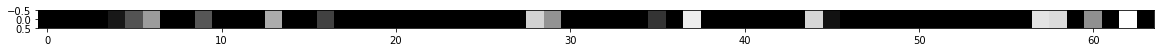


 ______________________________________________________________________________________________________________________________________________________ 
 dropout_3/cond/Merge:0


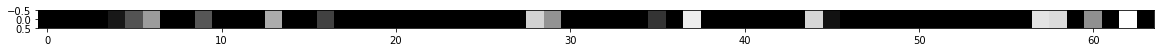


 ______________________________________________________________________________________________________________________________________________________ 
 dense_5/BiasAdd:0


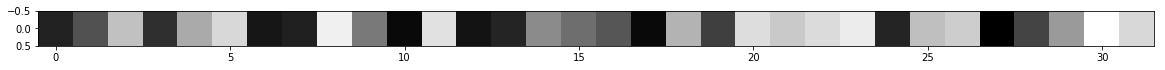


 ______________________________________________________________________________________________________________________________________________________ 
 activation_11/Relu:0


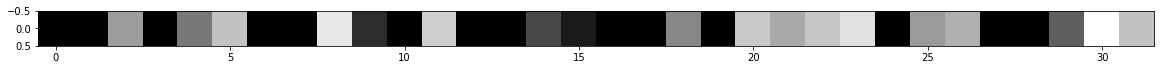


 ______________________________________________________________________________________________________________________________________________________ 
 dropout_4/cond/Merge:0


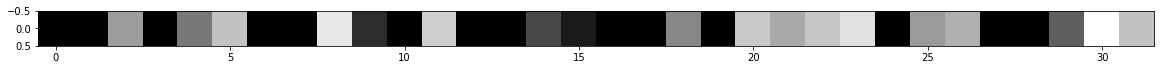


 ______________________________________________________________________________________________________________________________________________________ 
 dense_6/BiasAdd:0


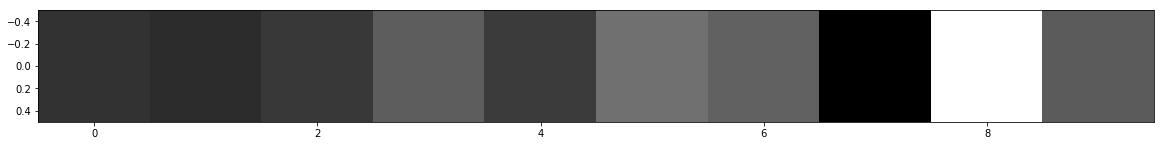


 ______________________________________________________________________________________________________________________________________________________ 
 activation_12/Softmax:0


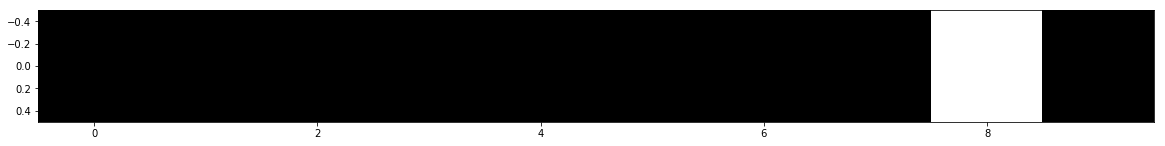

In [67]:
print("\n", "_" * 150, "\n", "sample image:")
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.show()

for i in range(0,9):
  c = int(layers[i].shape[3])
  fig, axis = plt.subplots(c // 16, 16, figsize=(20,5 * c // 64))
  print("\n", "_" * 150, "\n", layers[i].name)
  for j in range(0, c):
    image = output[i][0,:,:,j]
    axis[j // 16][j%16].imshow(image, cmap='gray')
  plt.show()
  
for i in range(9, 18):
  fig, axis = plt.subplots(1, 1, figsize=(20, 10))
  print("\n", "_" * 150, "\n", layers[i].name)
  image = output[i].reshape(1, output[i].shape[1])
  axis.imshow(image, cmap='gray')
  plt.show()


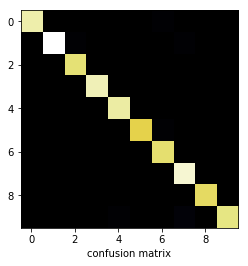

In [68]:
y_predict = model.predict(x_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))

plt.imshow(cm, cmap='CMRmap')
plt.xlabel('confusion matrix')
plt.show()


In [69]:
y_validation = model.predict(x_validation)
print(y_validation.argmax(axis=1))

[2 0 9 ... 3 9 2]
